# Business Case 4 - Recommender system

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k 
from tqdm import tqdm
import math
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.style as style
from matplotlib.lines import Line2D
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from typing import List
sns.set_style('whitegrid')
style.use('fast')

# Data Exploration

In [2]:
# Read csv files
df = pd.read_csv('retail.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [5]:
# encode Date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.astype({'CustomerID': object})

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [6]:
# Describe dataset
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [7]:
# Pandas profiling
#ProfileReport(df)

In [8]:
# check if all rows from same order are without customer
df.groupby('InvoiceNo')['CustomerID'].max().isnull().sum() == len(df.loc[df['CustomerID'].isnull(),'InvoiceNo'].unique())

True

In [9]:
df['CustomerID'].isnull().sum()/len(df) *100

24.926694334288598

In [10]:
# Create binary variable for cancelled orders
df['Cancellation'] = df['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)

In [11]:
df[df['Cancellation']==1] # len 9288 
len(df[df['Cancellation']==1])/len(df) *100

1.7139409015166756

In [12]:
# Not all the orders with negative quantities are cancellations
df[df['Quantity']<0]['Cancellation'].value_counts()

1    9288
0    1336
Name: Cancellation, dtype: int64

In [13]:
df[(df['Quantity']<0) & (df['Cancellation']==0)]#['Description'].unique()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


In [14]:
# Orders with negative quantities have all the prices equal to 0 and missing customer ID
df[(df['Quantity']<0) & (df['Cancellation']==0)]['UnitPrice'].unique() # 0
df[(df['Quantity']<0) & (df['Cancellation']==0)]['CustomerID'].unique() # nan

array([nan])

In [15]:
# Missing values
df.isna().sum()

InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
Cancellation         0
dtype: int64

In [16]:
len(df[df['UnitPrice']==0])

2515

In [17]:
len(df[df['UnitPrice']<0])

2

In [18]:
###### Major treatment before studying the statistics 
df = df[~(df['UnitPrice']<0)] # 2 observations with negative prices and there is no information about them 

In [19]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,0
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,0
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,0
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,0
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom,0
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,0
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom,0
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom,0


In [20]:
len(df.loc[df.duplicated(keep=False), :])/len(df) * 100 # almost 2% of the data

1.872461510923461

In [21]:
# replace nans
df['CustomerID'].replace(np.nan,'notRegistered',inplace=True)
df['Description'].replace(np.nan,'noDescription',inplace=True)

C:\Users\betty\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [22]:
# Check duplicated observations wihtout quantity column - same product in a specific order that instead of summing the quantity is added in a different row
df.loc[df[['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country', 'Cancellation']].duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation
113,536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom,0
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311,United Kingdom,0
483,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,3,2010-12-01 11:45:00,6.35,17908,United Kingdom,0
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom,0
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446,United Kingdom,0
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,2011-12-09 11:34:00,0.65,14446,United Kingdom,0
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2011-12-09 11:34:00,5.45,14446,United Kingdom,0
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446,United Kingdom,0


In [23]:
# we want to have only one row by product and order so we aggregated the duplicateds and sum the quantities by product per each order
df_agg = df.groupby(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country', 'Cancellation'])['Quantity'].sum().reset_index()
df_agg

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,0,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,0,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
...,...,...,...,...,...,...,...,...,...
531801,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,2011-12-09 09:57:00,0.83,14397,United Kingdom,1,-11
531802,C581499,M,Manual,2011-12-09 10:28:00,224.69,15498,United Kingdom,1,-1
531803,C581568,21258,VICTORIAN SEWING BOX LARGE,2011-12-09 11:57:00,10.95,15311,United Kingdom,1,-5
531804,C581569,20979,36 PENCILS TUBE RED RETROSPOT,2011-12-09 11:58:00,1.25,17315,United Kingdom,1,-5


In [24]:
(len(df)-len(df_agg))/len(df) * 100

1.8639729695316725

In [25]:
# Drop Cancellations since we have the original invoice about the same product
df_treated = df_agg[(df_agg['Cancellation'] == 0)]
df_treated

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,0,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,0,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
...,...,...,...,...,...,...,...,...,...
522583,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,2.10,12680,France,0,6
522584,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4.15,12680,France,0,4
522585,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4.15,12680,France,0,4
522586,581587,23256,CHILDRENS CUTLERY SPACEBOY,2011-12-09 12:50:00,4.15,12680,France,0,4


In [26]:
(len(df_agg)-len(df_treated))/len(df_agg) * 100

1.7333388491291937

In [27]:
# save customers without id to a new dataframe to have a different recommendation system
df_newCostumers = df_treated[df_treated['CustomerID']=='notRegistered']
df_newCostumers

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity
578,536414,22139,noDescription,2010-12-01 11:52:00,0.00,notRegistered,United Kingdom,0,56
1352,536544,11001,ASSTD DESIGN RACING CAR PEN,2010-12-01 14:32:00,3.36,notRegistered,United Kingdom,0,3
1353,536544,16236,KITTY PENCIL ERASERS,2010-12-01 14:32:00,0.43,notRegistered,United Kingdom,0,1
1354,536544,16237,SLEEPING CAT ERASERS,2010-12-01 14:32:00,0.43,notRegistered,United Kingdom,0,4
1355,536544,16238,PARTY TIME PENCIL ERASERS,2010-12-01 14:32:00,0.43,notRegistered,United Kingdom,0,1
...,...,...,...,...,...,...,...,...,...
522235,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,2011-12-09 10:26:00,4.13,notRegistered,United Kingdom,0,4
522236,581498,85150,LADIES & GENTLEMEN METAL SIGN,2011-12-09 10:26:00,4.96,notRegistered,United Kingdom,0,1
522237,581498,85174,S/4 CACTI CANDLES,2011-12-09 10:26:00,10.79,notRegistered,United Kingdom,0,1
522238,581498,DOT,DOTCOM POSTAGE,2011-12-09 10:26:00,1714.17,notRegistered,United Kingdom,0,1


In [28]:
# before taking the missing customers we save them into the apriori input 
df_apriori = df_treated.copy()

In [29]:
# take them out from the data to have a presonalized recommendation system
df_treated = df_treated[df_treated['CustomerID']!='notRegistered']
df_treated

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,0,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,0,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
...,...,...,...,...,...,...,...,...,...
522582,581587,22730,ALARM CLOCK BAKELIKE IVORY,2011-12-09 12:50:00,3.75,12680,France,0,4
522583,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,2.10,12680,France,0,6
522584,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4.15,12680,France,0,4
522585,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4.15,12680,France,0,4


In [30]:
###### Analysis of the description variable on the original data
df.groupby('StockCode')['Description'].unique()

StockCode
10002                [INFLATABLE POLITICAL GLOBE , noDescription]
10080            [GROOVY CACTUS INFLATABLE, noDescription, check]
10120                                              [DOGGY RUBBER]
10123C                     [HEARTS WRAPPING TAPE , noDescription]
10123G                                            [noDescription]
                                      ...                        
gift_0001_20    [Dotcomgiftshop Gift Voucher £20.00, to push o...
gift_0001_30    [Dotcomgiftshop Gift Voucher £30.00, noDescrip...
gift_0001_40                 [Dotcomgiftshop Gift Voucher £40.00]
gift_0001_50                 [Dotcomgiftshop Gift Voucher £50.00]
m                                                        [Manual]
Name: Description, Length: 4070, dtype: object

In [31]:
# There are a lot of products with more than on description
df.groupby('StockCode')['Description'].nunique().value_counts()

1    2746
2    1069
3     185
4      50
5      14
7       2
6       2
9       1
8       1
Name: Description, dtype: int64

In [32]:
# A product can also have a lot of different prices 
df.groupby('StockCode')['UnitPrice'].nunique().value_counts()#.sum()

3      801
4      786
5      649
2      573
1      468
6      357
7      220
8       85
9       53
10      26
11      17
12      17
13       5
16       3
14       2
687      1
26       1
30       1
114      1
75       1
15       1
59       1
260      1
Name: UnitPrice, dtype: int64

In [33]:
# Get the most frequent definition for a specific stockcode
df.groupby('StockCode')['Description'].value_counts().groupby('StockCode').head(1)

StockCode     Description                       
10002         INFLATABLE POLITICAL GLOBE            71
10080         GROOVY CACTUS INFLATABLE              22
10120         DOGGY RUBBER                          30
10123C        HEARTS WRAPPING TAPE                   3
10123G        noDescription                          1
                                                    ..
gift_0001_20  Dotcomgiftshop Gift Voucher £20.00     9
gift_0001_30  Dotcomgiftshop Gift Voucher £30.00     7
gift_0001_40  Dotcomgiftshop Gift Voucher £40.00     3
gift_0001_50  Dotcomgiftshop Gift Voucher £50.00     4
m             Manual                                 1
Name: Description, Length: 4070, dtype: int64

In [34]:
# From the metadata: StockCode is a 5-digit code but there are products not following this format
df[df['StockCode'].apply(lambda x:len(x))<5]['StockCode'].value_counts() # 10 products with len less than 5 digits

POST    1256
DOT      710
M        571
C2       144
D         77
S         63
CRUK      16
PADS       4
m          1
B          1
Name: StockCode, dtype: int64

In [35]:
doubtful_products= df[df['StockCode'].apply(lambda x:len(x))<5]['StockCode'].value_counts().index
df[df['StockCode'].isin(doubtful_products)].groupby('StockCode')['UnitPrice'].nunique() 
# Products with a high fluctuation of prices

StockCode
B         1
C2        6
CRUK     16
D        75
DOT     687
M       260
PADS      2
POST    114
S        59
m         1
Name: UnitPrice, dtype: int64

In [36]:
# The product's description to understand what are we dealing with
df[df['StockCode'].isin(doubtful_products)].groupby('StockCode')['Description'].value_counts()

StockCode  Description               
B          Adjust bad debt                  1
C2         CARRIAGE                       143
           noDescription                    1
CRUK       CRUK Commission                 16
D          Discount                        77
DOT        DOTCOM POSTAGE                 709
           noDescription                    1
M          Manual                         571
PADS       PADS TO MATCH ALL CUSHIONS       4
POST       POSTAGE                       1252
           noDescription                    4
S          SAMPLES                         63
m          Manual                           1
Name: Description, dtype: int64

In [37]:
# Proportion of transactions with these products
df2 = df[~df['StockCode'].isin(doubtful_products)]
(len(df)-len(df2))/len(df) * 100

0.5246287647142406

In [38]:
## take the doubtful products also from the apriori algorithm 
df_apriori = df_apriori[~df_apriori['StockCode'].isin(doubtful_products)]

In [39]:
##### From the treated data
doubtful_products2 = df_treated[df_treated['StockCode'].apply(lambda x:len(x))<5]['StockCode'].value_counts().index
df_treated[df_treated['StockCode'].isin(doubtful_products2)].groupby('StockCode')['UnitPrice'].nunique() 
# Products with a high flutuation of prices

StockCode
C2        4
DOT      16
M       106
PADS      2
POST     32
Name: UnitPrice, dtype: int64

In [40]:
df_treated[df_treated['StockCode'].isin(doubtful_products2)].groupby('StockCode')['Description'].unique()
# Postage, Carriage and dotcom postage - tax fees?
# Manual doesnt seem like a product
# Pads is probably a product but badly identified ?

StockCode
C2                        [CARRIAGE]
DOT                 [DOTCOM POSTAGE]
M                           [Manual]
PADS    [PADS TO MATCH ALL CUSHIONS]
POST                       [POSTAGE]
Name: Description, dtype: object

In [41]:
# Drop all products except pads
df_final = df_treated[~df_treated['StockCode'].isin(['C2','DOT','M','POST'])]
df_final

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,4.25,17850,United Kingdom,0,6
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,7.65,17850,United Kingdom,0,2
2,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,6
...,...,...,...,...,...,...,...,...,...
522582,581587,22730,ALARM CLOCK BAKELIKE IVORY,2011-12-09 12:50:00,3.75,12680,France,0,4
522583,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,2.10,12680,France,0,6
522584,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4.15,12680,France,0,4
522585,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4.15,12680,France,0,4


### Further Exploration

Text(0.5,0,'Number of different Products')

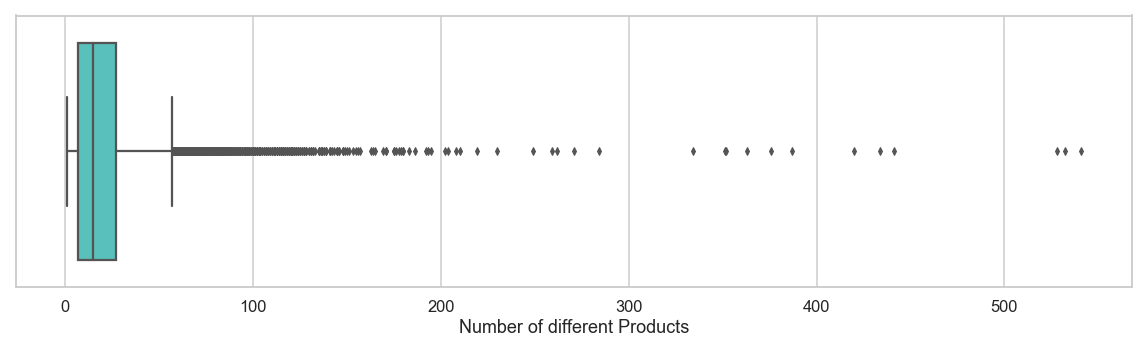

In [42]:
# Number of products inside an transaction
nproducts_byTransaction = df_final.groupby('InvoiceNo').size()
sns.set_context("talk")
ax = plt.subplots(figsize = (20,5))
ax = sns.boxplot(x= nproducts_byTransaction, color = 'mediumturquoise')
ax.set_xlabel("Number of different Products", fontsize=18)

In [43]:
nproducts_byTransaction.describe()

count    18416.000000
mean        20.984416
std         23.845872
min          1.000000
25%          7.000000
50%         15.000000
75%         27.000000
max        541.000000
dtype: float64

Text(0.5,0,'Number of Products')

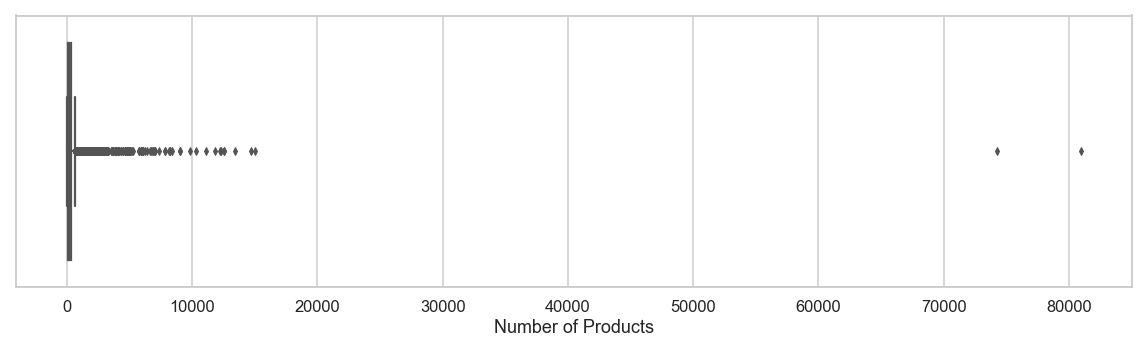

In [44]:
# Total quantity of products inside an order
Tquantity_byTransaction = df_final.groupby('InvoiceNo')['Quantity'].sum()
sns.set_context("talk")
ax = plt.subplots(figsize = (20,5))
ax = sns.boxplot(x=Tquantity_byTransaction, color = 'mediumturquoise')
ax.set_xlabel("Number of Products", fontsize=18)

In [45]:
Tquantity_byTransaction.describe()

count    18416.000000
mean       280.801857
std        979.351211
min          1.000000
25%         75.000000
50%        156.000000
75%        292.000000
max      80995.000000
Name: Quantity, dtype: float64

Text(0.5,0,'Number of Products')

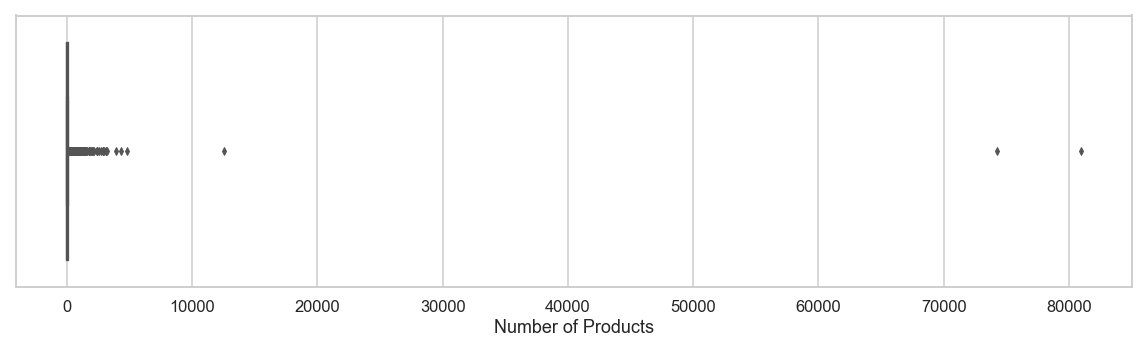

In [46]:
# Max quantity of products inside an order
Maxquantity_byTransaction=df_final.groupby('InvoiceNo')['Quantity'].max()
sns.set_context("talk")
ax = plt.subplots(figsize = (20,5))
ax = sns.boxplot(x=Maxquantity_byTransaction, color = 'mediumturquoise')
ax.set_xlabel("Number of Products", fontsize=18)

In [47]:
Maxquantity_byTransaction.describe()

count    18416.00000
mean        69.51705
std        828.01072
min          1.00000
25%         12.00000
50%         24.00000
75%         48.00000
max      80995.00000
Name: Quantity, dtype: float64

Text(0.5,0,'Number of Orders')

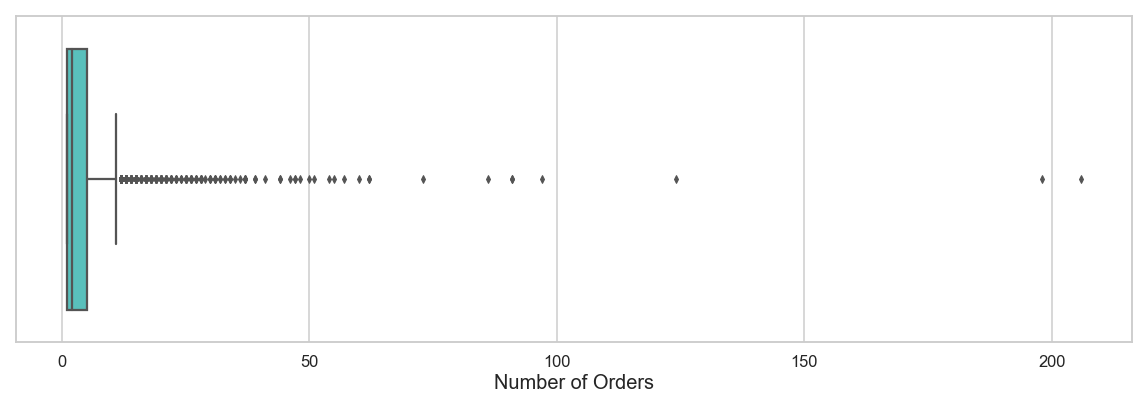

In [48]:
# Number of transactions by Customer
ntransactions_byCustomer = df_final.groupby(['CustomerID'])['InvoiceNo'].nunique()
ax = plt.subplots(figsize = (20,6))
ax = sns.boxplot(x=ntransactions_byCustomer, color = 'mediumturquoise')
ax.set_xlabel("Number of Orders", fontsize=20)

In [49]:
ntransactions_byCustomer.describe()

count    4336.000000
mean        4.247232
std         7.639830
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

Text(0.5,0,'Number of Transactions')

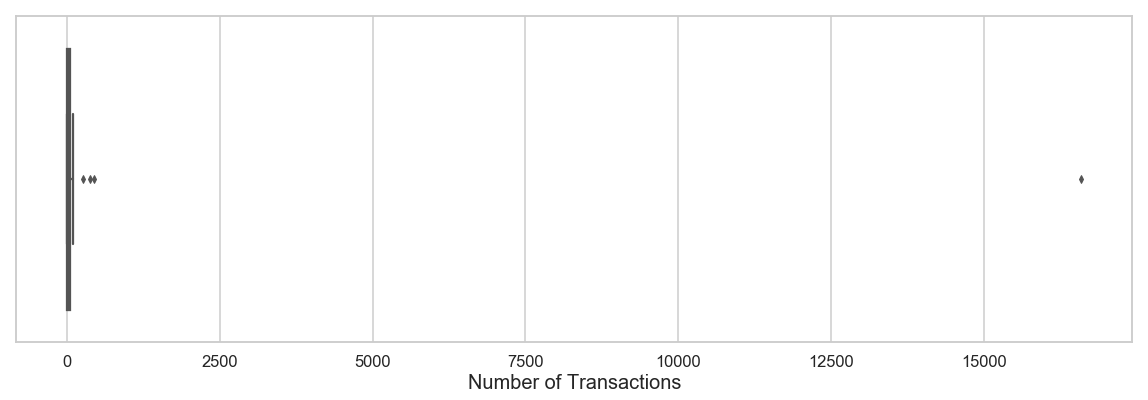

In [50]:
# Number of transactions by Country
ntransactions_byCountry = df_final.groupby(['Country'])['InvoiceNo'].nunique()
ax = plt.subplots(figsize = (20,6))
ax = sns.boxplot(x=ntransactions_byCountry, color = 'mediumturquoise')
ax.set_xlabel("Number of Transactions", fontsize=20)

In [51]:
Percentage_transactions_byCountry = ntransactions_byCountry / ntransactions_byCountry.sum()
Percentage_transactions_byCountry.sort_values(ascending=False)

Country
United Kingdom          0.900956
Germany                 0.024055
France                  0.020580
EIRE                    0.013901
Belgium                 0.005321
Netherlands             0.005104
Spain                   0.004778
Australia               0.003041
Portugal                0.002661
Switzerland             0.002552
Finland                 0.002172
Italy                   0.001901
Sweden                  0.001846
Norway                  0.001738
Channel Islands         0.001358
Poland                  0.001032
Japan                   0.001032
Denmark                 0.000977
Austria                 0.000923
Cyprus                  0.000760
Unspecified             0.000434
Iceland                 0.000380
Canada                  0.000272
USA                     0.000272
Malta                   0.000272
Greece                  0.000272
Israel                  0.000272
Lithuania               0.000217
Singapore               0.000217
European Community      0.000163
Cz

In [52]:
ntransactions_byCountry.describe()

count       37.00000
mean       497.72973
std       2721.18788
min          1.00000
25%          4.00000
50%         17.00000
75%         47.00000
max      16592.00000
Name: InvoiceNo, dtype: float64

<ipython-input-53-6f562f294f65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Price'] = df_final['Quantity']*df_final['UnitPrice']


Text(0.5,0,'Transaction Bill')

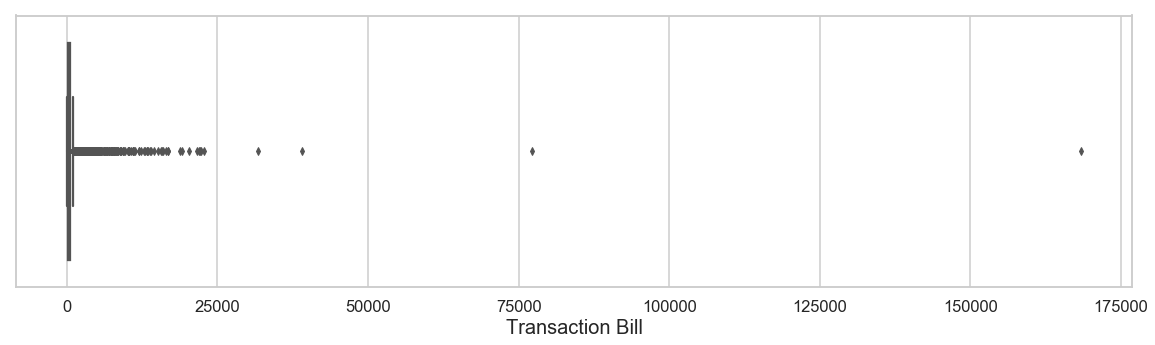

In [53]:
# Transaction bill
df_final['Price'] = df_final['Quantity']*df_final['UnitPrice']
MoneySpent_byTransaction = df_final.groupby(['InvoiceNo'])['Price'].sum()
ax = plt.subplots(figsize = (20,5))
ax = sns.boxplot(x=MoneySpent_byTransaction, color = 'mediumturquoise')
ax.set_xlabel("Transaction Bill", fontsize=20)

In [54]:
MoneySpent_byTransaction.describe()

count     18416.000000
mean        475.740207
std        1678.308060
min           0.000000
25%         157.657500
50%         302.170000
75%         464.857500
max      168469.600000
Name: Price, dtype: float64

Text(2500,2080,'Mean: 475.74 \nMedian: 302.17\nQ25: 157.66\nQ75: 464.86')

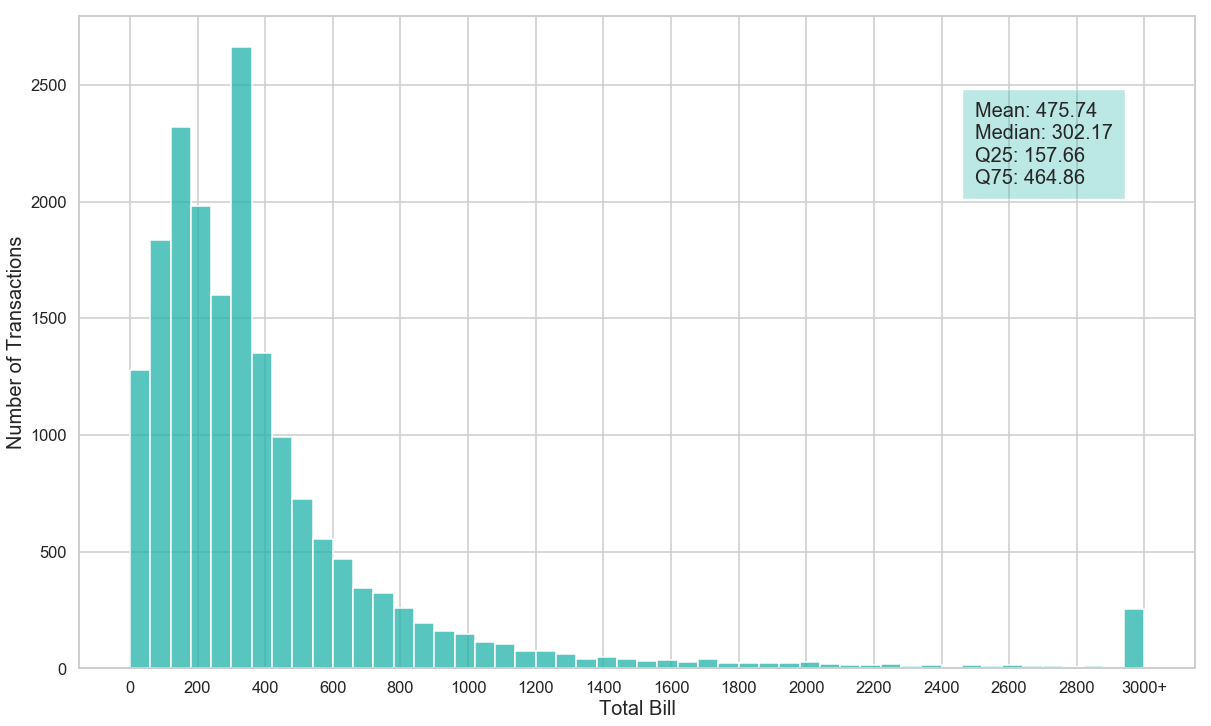

In [55]:
ax = plt.subplots(figsize = (20,12))
ax = sns.histplot(data=MoneySpent_byTransaction.apply(lambda x: 3000 if x>=3000 else x), bins=50, color='lightseagreen')
ax.set_xlabel("Total Bill", fontsize=20)
ax.set_ylabel("Number of Transactions", fontsize=20)
plt.xticks(np.arange(0, 3000+1, 200))
ax.set_xticklabels(list(np.arange(0, 3000, 200)) +['3000+'])
ax.text(2500, 2080, 'Mean: 475.74 \nMedian: 302.17\nQ25: 157.66\nQ75: 464.86', fontsize=20,
        bbox={'facecolor': 'lightseagreen','edgecolor': 'white', 'alpha': 0.3, 'pad': 12})

In [56]:
product_transaction = df_final.groupby(['Description'])['InvoiceNo'].count().sort_values(ascending=False)
product_transaction

Description
WHITE HANGING HEART T-LIGHT HOLDER     1971
REGENCY CAKESTAND 3 TIER               1705
JUMBO BAG RED RETROSPOT                1600
PARTY BUNTING                          1380
ASSORTED COLOUR BIRD ORNAMENT          1375
                                       ... 
LILAC FEATHERS CURTAIN                    1
INCENSE BAZAAR PEACH                      1
BLACK VINT ART DEC CRYSTAL BRACELET       1
BLACKCHRISTMAS TREE 30CM                  1
MUMMY MOUSE RED GINGHAM RIBBON            1
Name: InvoiceNo, Length: 3873, dtype: int64

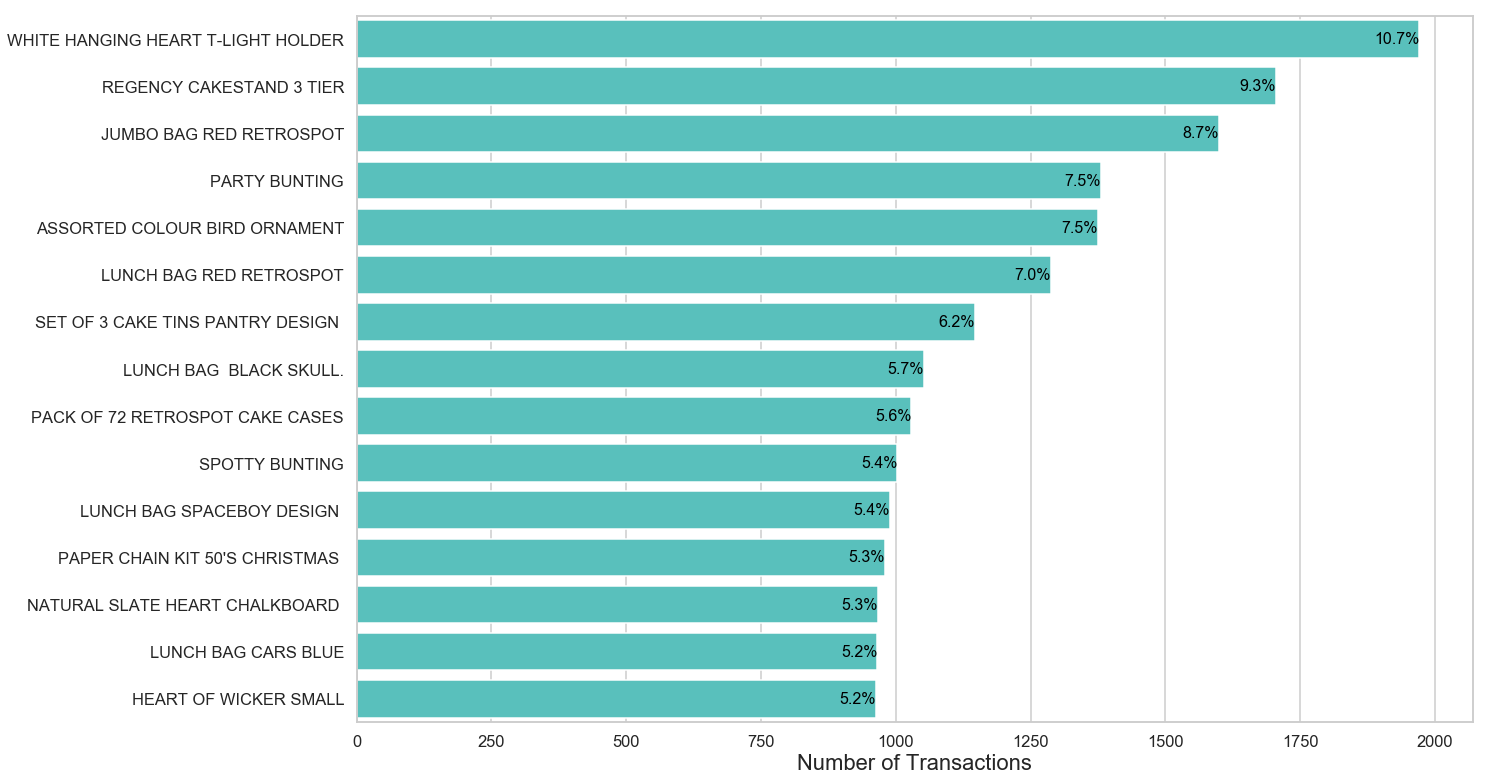

In [57]:
fig, ax = plt.subplots(figsize = (20,13))
ax = sns.barplot(y = product_transaction.index[0:15], x = product_transaction.values[0:15], color='mediumturquoise', label = "total")
ax.set_ylabel("")
ax.set_xlabel("Number of Transactions", fontsize=22)
i=0
percentage = ['{:.1f}%'.format(percent) for percent in (product_transaction/df_final['InvoiceNo'].nunique() * 100).values]
for p in ax.patches[-20:]:
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage[i], (x, y), ha="right", va="center", fontsize=16, color='black')
        i+=1
plt.show()

In [58]:
def long_tail_plot(df, item_id_column, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
        
    
    Credits: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py
    """
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = plt.subplots(figsize = (20,15))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    #ax.set_title('Long Tail Plot',size=20)
    ax.set_ylabel('Number of Transactions', size=18)
    ax.set_xlabel('Products', size=18)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="mediumturquoise", alpha=0.3)
        ax.fill_between(x2, y2,  color="plum", alpha=0.3)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': products in the head', markerfacecolor='mediumturquoise', markersize=15),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': products in the tail', markerfacecolor='plum', markersize=15)]
        ax.legend(handles=legend_elements, loc=1,prop={'size': 22})

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="mediumturquoise", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

C:\Users\betty\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


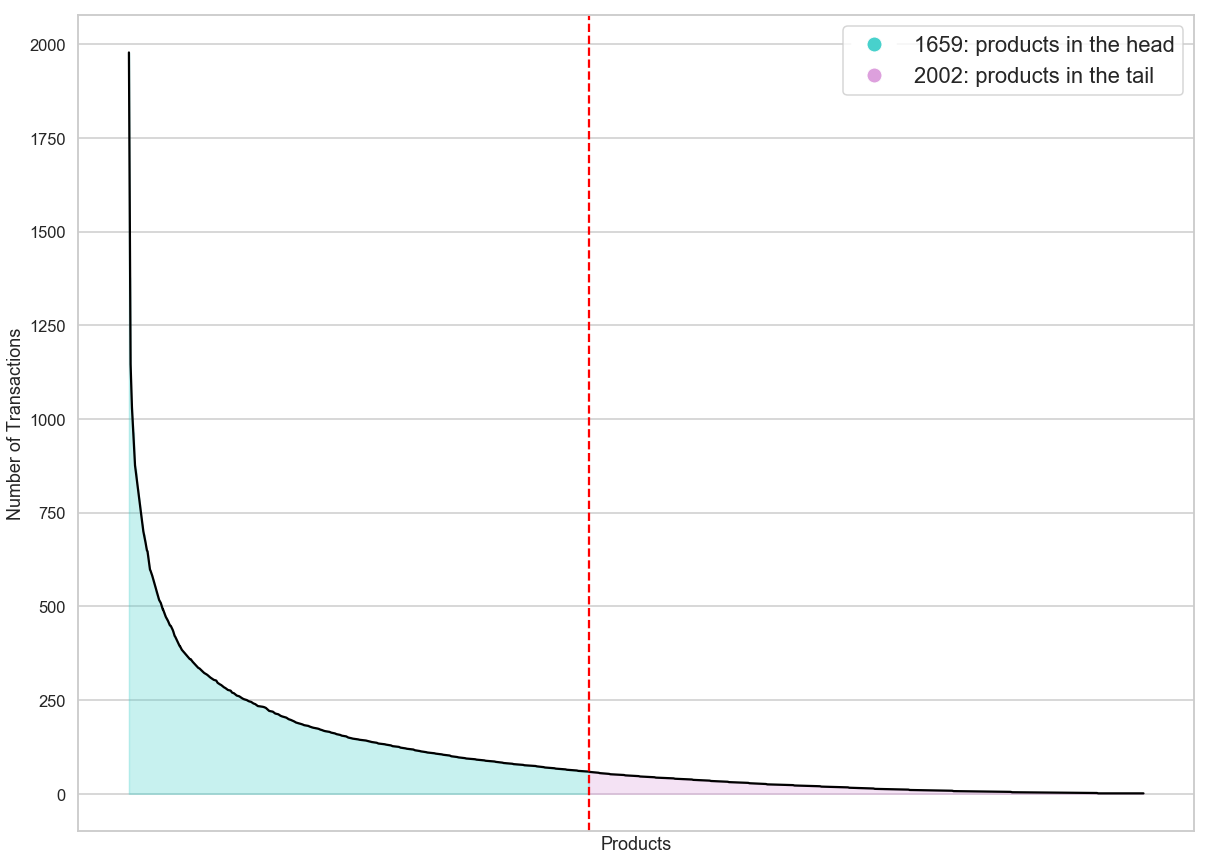

In [59]:
long_tail_plot(df_final, 'StockCode', percentage= 0.9, x_labels= False)

In [60]:
products_byMonth = df_final.groupby(df_final['InvoiceDate'].dt.month)['InvoiceNo'].count()
products_byMonth

InvoiceDate
1     20685
2     19427
3     26500
4     22195
5     27773
6     26627
7     26245
8     26455
9     39179
10    47840
11    61686
12    41837
Name: InvoiceNo, dtype: int64

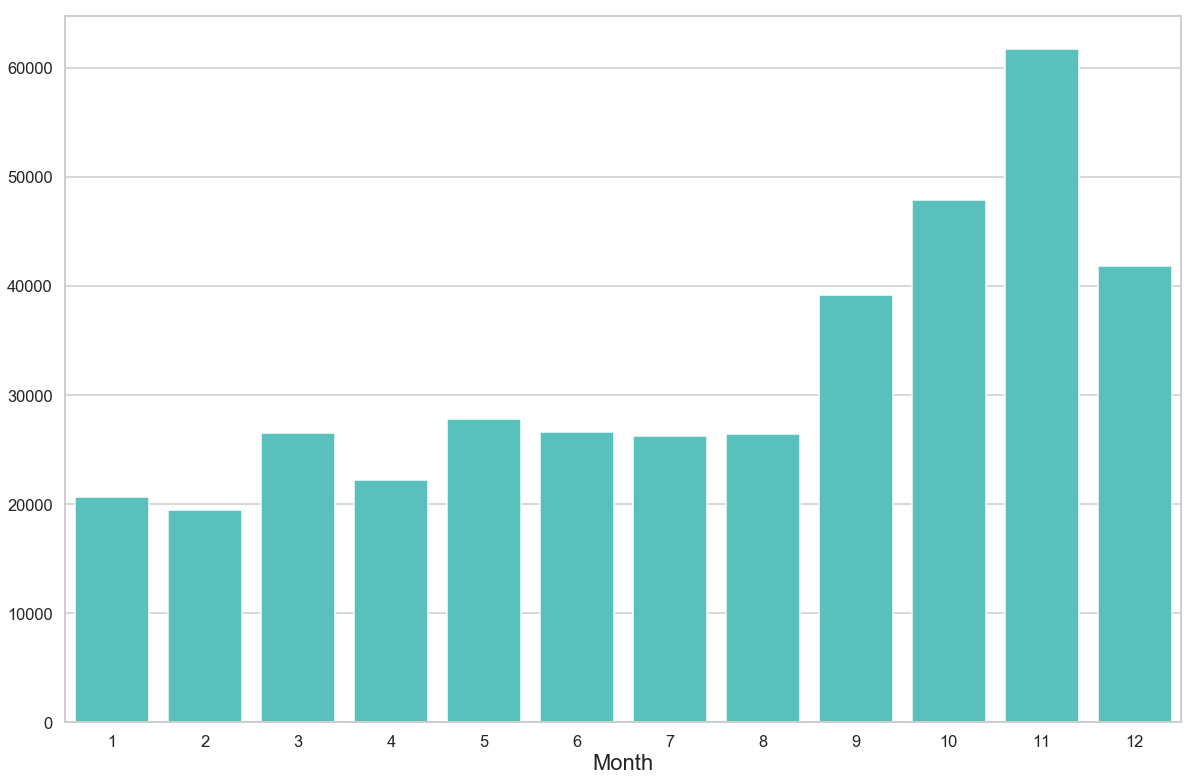

In [61]:
fig, ax = plt.subplots(figsize = (20,13))
ax = sns.barplot(x = products_byMonth.index, y = products_byMonth.values, color='mediumturquoise', label = "total")
ax.set_ylabel("")
ax.set_xlabel("Month", fontsize=22)
plt.show()

In [62]:
products_byHour = df_final.groupby(df_final['InvoiceDate'].dt.hour)['InvoiceNo'].count()
products_byHour

InvoiceDate
6         1
7       375
8      8623
9     21776
10    37381
11    47561
12    69624
13    61881
14    52318
15    44078
16    23291
17    12757
18     2870
19     3156
20      757
Name: InvoiceNo, dtype: int64

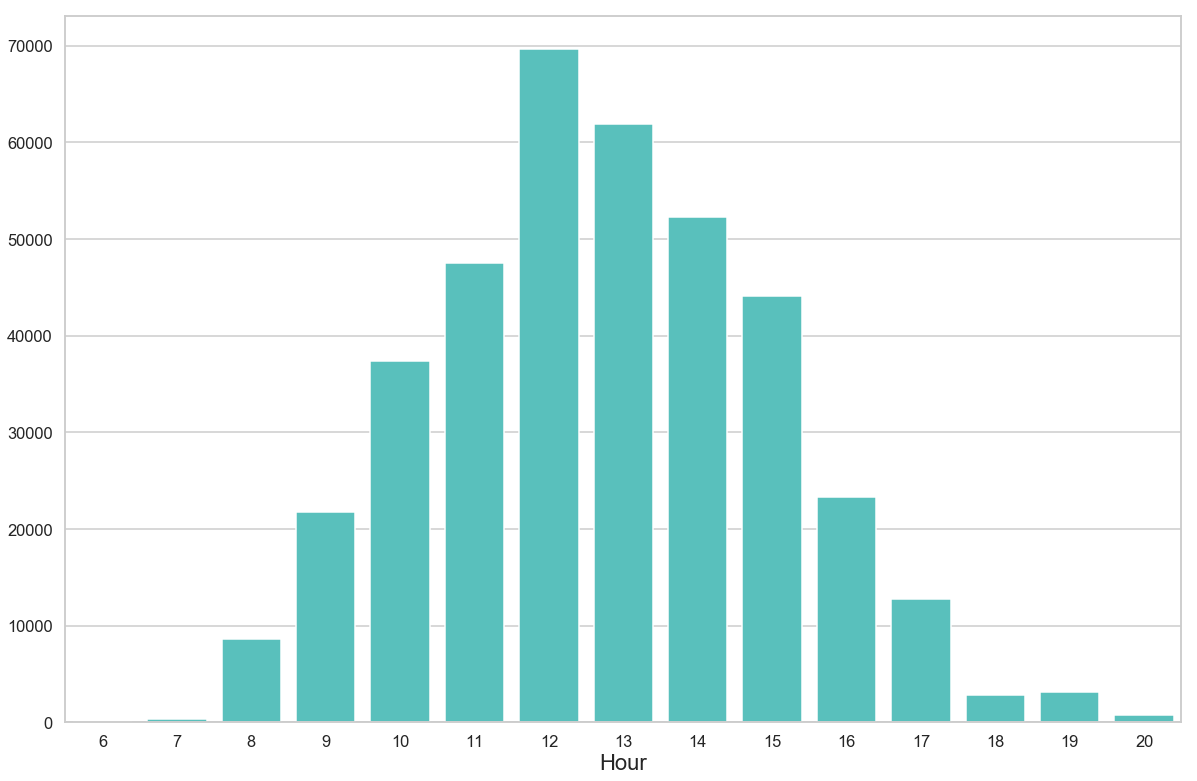

In [63]:
fig, ax = plt.subplots(figsize = (20,13))
ax = sns.barplot(x = products_byHour.index, y = products_byHour.values, color='mediumturquoise', label = "total")
ax.set_ylabel("")
ax.set_xlabel("Hour", fontsize=22)
plt.show()

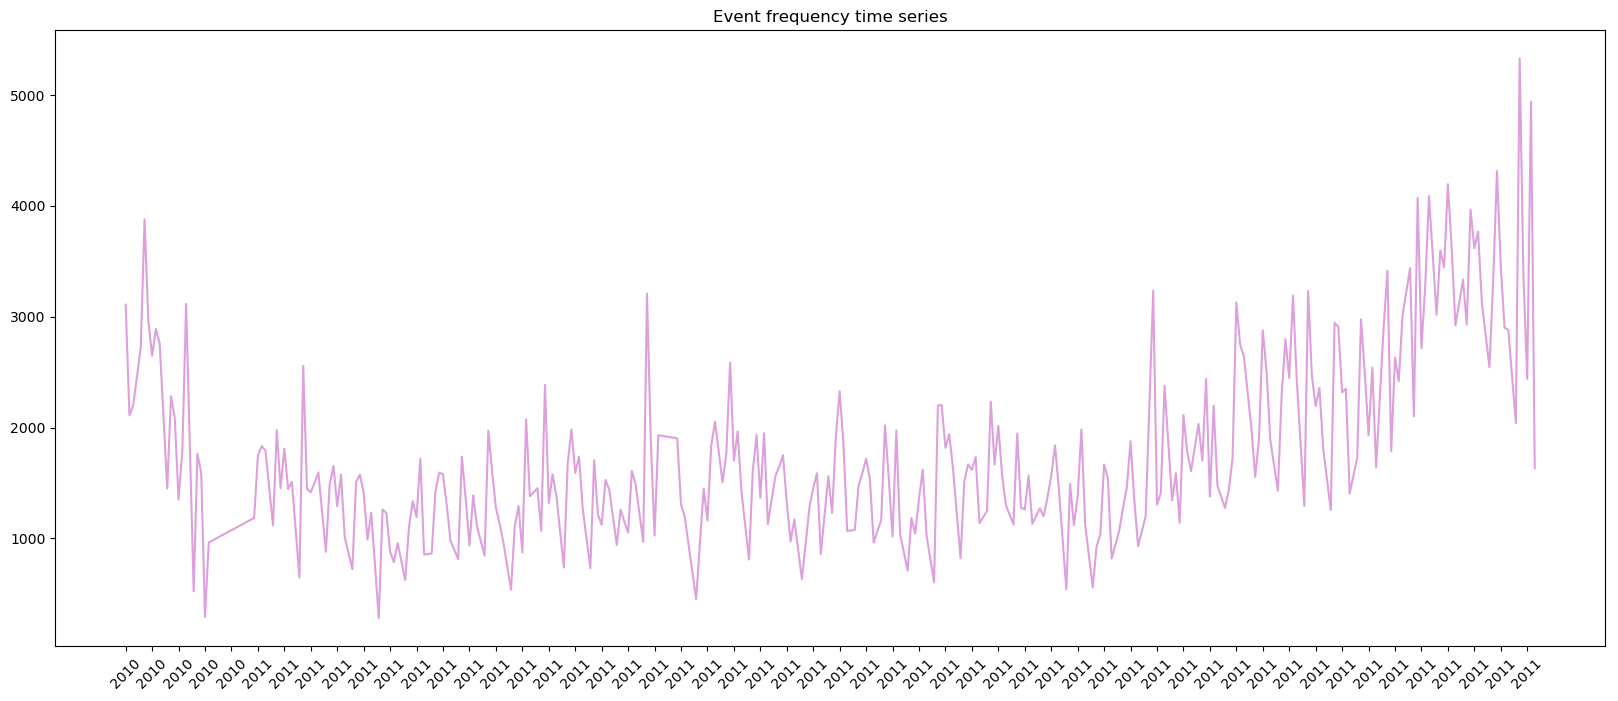

In [64]:
style.use('default')
# Visualize number of events per day
data = pd.DatetimeIndex(df['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(20,8))
plt.plot(data.index, data.values, linestyle="-", color='plum')
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

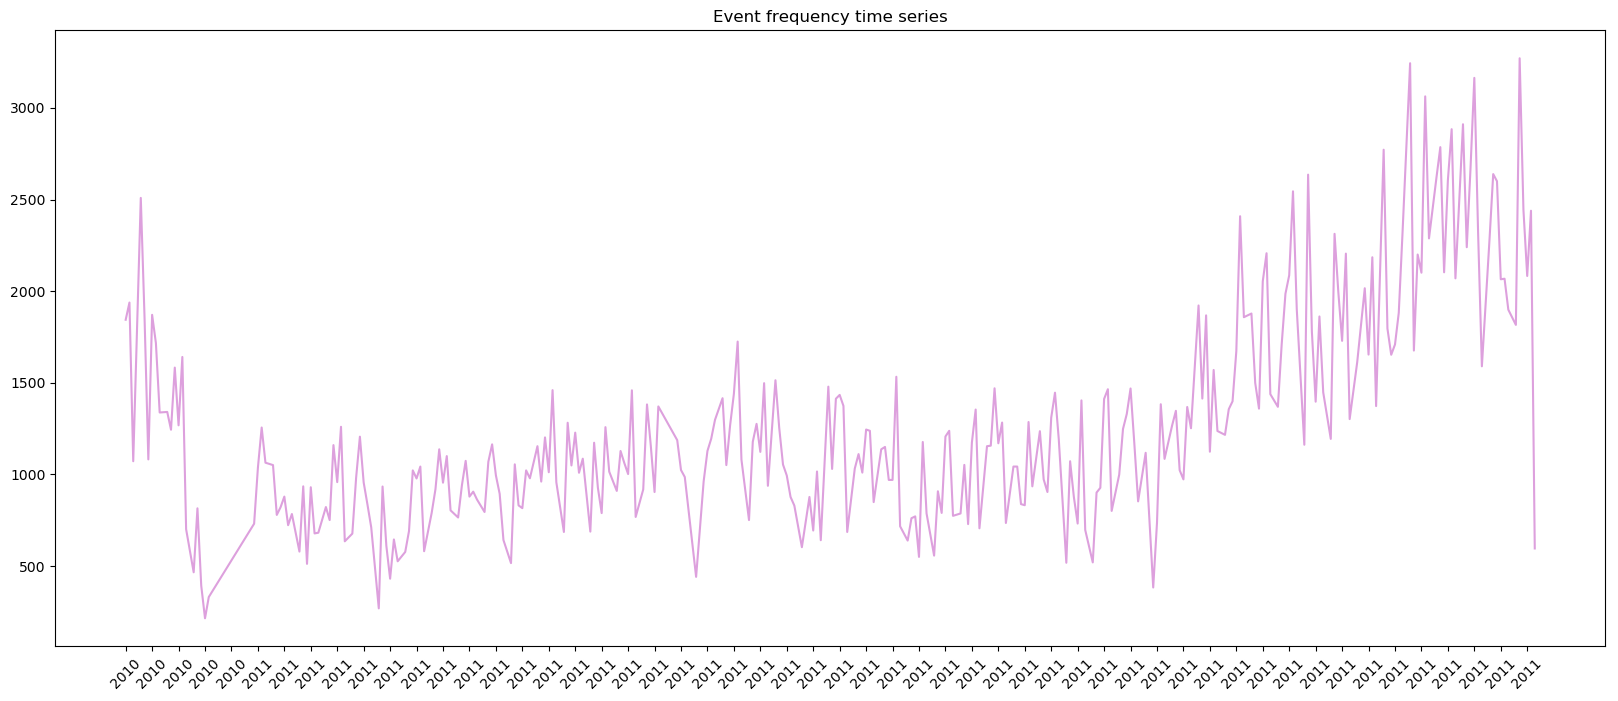

In [65]:
style.use('default')
# Visualize number of events per day
data = pd.DatetimeIndex(df_final['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(20,8))
plt.plot(data.index, data.values, linestyle="-", color='plum')
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.title('Event frequency time series')
plt.show()

In [66]:
# How many weeks does the dataset has?
diff = (data.index.max() - data.index.min())
print(f"The dataset has {diff.days} days, corresponding to {diff.days//7} weeks.")

The dataset has 373 days, corresponding to 53 weeks.


## Outlier Analysis
Looking to the previous boxplots we came up with the following thresholds

* Variable 1: Number of Products (Total quantity) by Transaction

In [67]:
# select orders with less than 70000 products' quantity
filter1 = Tquantity_byTransaction[Tquantity_byTransaction<70000].index
df1 = df_final[df_final['InvoiceNo'].isin(filter1)]

In [68]:
# excluded 2 orders
df_final['InvoiceNo'].nunique() - df1['InvoiceNo'].nunique()

2

In [69]:
len(df_final) - len(df1) #2 rows

2

In [70]:
# percentage of deleted data
(len(df_final) - len(df1))/len(df_final) * 100

0.0005175327145367177

In [71]:
len(df_final)

386449

* Variable 2: Transaction Bill

In [72]:
# select orders with less than a 168000 bill
filter2 = MoneySpent_byTransaction[MoneySpent_byTransaction<168000].index
df2 = df_final[df_final['InvoiceNo'].isin(filter2)]

In [73]:
# excluded 1 order
df_final['InvoiceNo'].nunique() - df2['InvoiceNo'].nunique()

1

In [74]:
len(df_final) - len(df2)

1

In [75]:
# percentage of deleted data
(len(df_final) - len(df2))/len(df_final) * 100

0.00025876635726835884

* Join all filters

In [76]:
df_final_out = df_final[(df_final['InvoiceNo'].isin(filter1)) & (df_final['InvoiceNo'].isin(filter2))]

In [77]:
# excluded 2 orders
df_final['InvoiceNo'].nunique() - df_final_out['InvoiceNo'].nunique()

2

In [78]:
len(df_final) - len(df_final_out)

2

In [79]:
# percentage of deleted data
(len(df_final) - len(df_final_out))/len(df_final) * 100

0.0005175327145367177

In [80]:
df_final = df_final_out.copy()

## Creation of the rating matrix (user-item)
Taking into account the matrix sparsity

In [81]:
def threshold_ratings(df, df_newCostumers, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min
        
        # save customers with less activity as new costumers (joining to the previous ones with no id)
        df_newCostumers = pd.concat([df_newCostumers, 
                   df[df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]
                  ])
        
        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [82]:
# get limited dataset
df_limited = threshold_ratings(df_final, df_newCostumers, 5, 10)

Raw dataset info 
-----------------
Number of users: 4335
Number of items: 3660
Sparsity: 2.436%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 4102
Number of items: 2861
Sparsity: 3.261%


We want to split the train and test events such that:
- all test events occur after all train events

In [83]:
# Train-test split
start_train = df_limited['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(46, unit='w')
end_test = start_test + pd.to_timedelta(7, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['InvoiceDate'] > start_train) & (df_limited['InvoiceDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.75


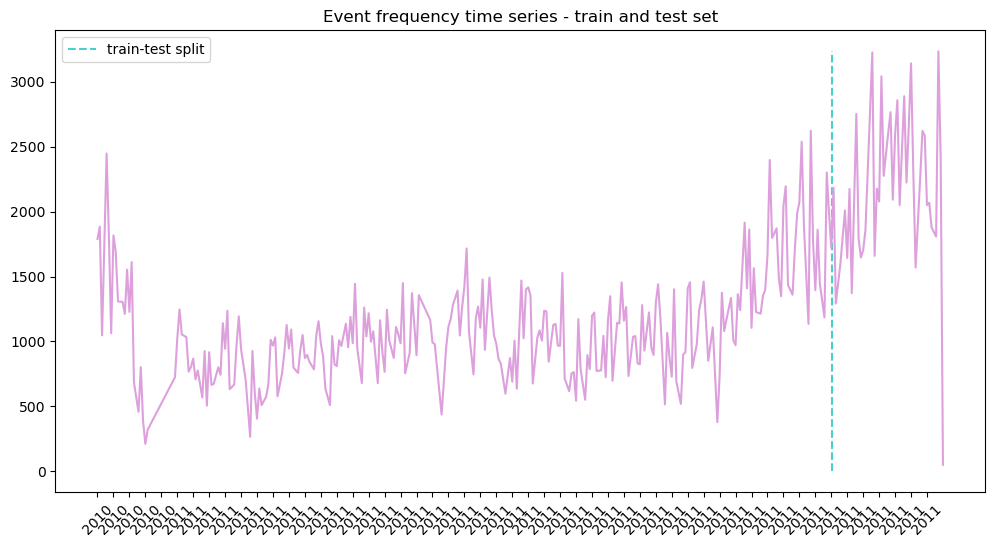

In [84]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-",color='plum')
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='mediumturquoise', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

In [85]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2861, 4094) and test set shape: (2861, 4094)
train set percentage of zeros: 98.25509987506119 and test set percentage of zeros: 99.32376465196509


In [86]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [87]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceNo,StockCode,Description,InvoiceDate,UnitPrice,CustomerID,Country,Cancellation,Quantity,Price,train_split
1978,536557,79321,CHILLI LIGHTS,2010-12-01 14:41:00,4.25,17841,United Kingdom,0,24,102.00,1
6740,536984,79321,CHILLI LIGHTS,2010-12-03 14:35:00,4.25,17841,United Kingdom,0,24,102.00,1
12433,537405,79321,CHILLI LIGHTS,2010-12-06 14:51:00,4.25,17841,United Kingdom,0,30,127.50,1
29247,538866,79321,CHILLI LIGHTS,2010-12-14 14:40:00,4.25,17841,United Kingdom,0,24,102.00,1
36115,539469,79321,CHILLI LIGHTS,2010-12-19 13:59:00,4.25,17841,United Kingdom,0,24,102.00,1
41218,540021,79321,CHILLI LIGHTS,2011-01-04 12:51:00,4.25,17841,United Kingdom,0,48,204.00,1
48086,540538,79321,CHILLI LIGHTS,2011-01-09 14:36:00,4.25,17841,United Kingdom,0,34,144.50,1
52436,540943,79321,CHILLI LIGHTS,2011-01-12 12:31:00,4.95,17841,United Kingdom,0,3,14.85,1
56561,541253,79321,CHILLI LIGHTS,2011-01-16 13:51:00,4.25,17841,United Kingdom,0,30,127.50,1
61494,541587,79321,CHILLI LIGHTS,2011-01-19 14:39:00,4.25,17841,United Kingdom,0,24,102.00,1


## Fit the ALS model

In [89]:
regularization = [0.05,0.01,0.005]
factors = [150,175,200,225,250]
iterations = [30,35,40]
alpha = [40,45,50]
score = 0

def get_score(model):
    return ranking_metrics_at_k(model, user_item_train, user_item_test, K=5, show_progress=True, num_threads=0)['auc']

for r in regularization:
    for f in factors:
        for i in iterations:
            als_model = AlternatingLeastSquares(factors=f, regularization=r, iterations=i, random_state=42)
            for a in alpha:
                als_model.fit((item_user_train * a).astype('double'))
                s = get_score(als_model)
                if s > score: 
                    score = s
                    als = als_model
                    params = {'regularization': r,
                             'factors': f,
                             'iterations': i,
                             'alpha': a}
                    print(params)
                else: continue

print(params)


{'regularization': 0.05, 'factors': 150, 'iterations': 30, 'alpha': 40}



{'regularization': 0.05, 'factors': 150, 'iterations': 30, 'alpha': 45}



{'regularization': 0.05, 'factors': 150, 'iterations': 30, 'alpha': 50}



{'regularization': 0.05, 'factors': 175, 'iterations': 30, 'alpha': 40}



{'regularization': 0.05, 'factors': 225, 'iterations': 30, 'alpha': 50}



{'regularization': 0.05, 'factors': 225, 'iterations': 35, 'alpha': 50}



{'regularization': 0.05, 'factors': 225, 'iterations': 40, 'alpha': 45}



{'regularization': 0.05, 'factors': 250, 'iterations': 30, 'alpha': 40}



{'regularization': 0.01, 'factors': 250, 'iterations': 30, 'alpha': 40}



{'regularization': 0.01, 'factors': 250, 'iterations': 35, 'alpha': 40}



{'regularization': 0.01, 'factors': 250, 'iterations': 35, 'alpha': 40}


# ALS model methods

In [90]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als.recommend(user_map[user_id], user_item_train)
list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

[('82482', 1.0028094),
 ('82494L', 1.0023217),
 ('82483', 1.0020066),
 ('85123A', 1.0009348),
 ('84406B', 1.0002003),
 ('20679', 0.9996598),
 ('21068', 0.9994856),
 ('84029E', 0.99888843),
 ('22752', 0.9988241),
 ('84029G', 0.9987587)]

In [91]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[('22632', 1.0),
 ('22866', 0.5820452),
 ('22633', 0.57825637),
 ('22867', 0.48387784),
 ('22865', 0.48275813),
 ('23439', 0.45230094),
 ('22834', 0.28957626),
 ('21117', 0.25391707),
 ('17012F', 0.24103938),
 ('84029E', 0.22726005)]

In [92]:
# show the top 10 items that explain the recommended item to the user
# It is possible to write the LVM as a linear function between preferences and past actions.
# We can then see what are the actions associated with the highest contributions to the given recommendation.
score, contributions, user_weights = als.explain(user_map[user_id], 
                                                       user_item_train,
                                                       item_map[item_id])
print("The score of the user/item pair is: ", score)
print("The top N (itemid, score) contributions for this user/item pair are:\n", list(map(lambda x: (get_keys(x[0], item_map), x[1]), contributions)))

The score of the user/item pair is:  0.880660927097415
The top N (itemid, score) contributions for this user/item pair are:
 [('22632', 0.6619762431269908), ('22633', 0.1520154896822474), ('84029E', 0.03961402231754693), ('82486', 0.01846491739059209), ('82482', 0.014747917553675289), ('71053', 0.01365478758359713), ('22752', 0.013261901822162017), ('21071', 0.009983974463113589), ('82483', 0.008393505758308705), ('22803', 0.007210549769330705)]


# Evaluation

In [93]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [94]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [95]:
# Evaluate models.
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=4, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.095360,0.060253
map,0.061715,0.036538
ndcg,0.100412,0.060119
auc,0.506615,0.504074


### For the new customers

In [98]:
# Train-test split
start_train = df_newCostumers['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(46, unit='w')
end_test = start_test + pd.to_timedelta(7, unit='w')

# Create new limited df
df_newCostumers = df_newCostumers.loc[(df_newCostumers['InvoiceDate'] > start_train) & (df_newCostumers['InvoiceDate'] <= end_test)]

# Create train_split flag
df_newCostumers['train_split'] = (df_newCostumers['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_newCostumers['train_split'].mean()))

Proportion of train events: 0.79


<ipython-input-98-914d5c98ee2c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_newCostumers['train_split'] = (df_newCostumers['InvoiceDate'] <= start_test).astype(int)


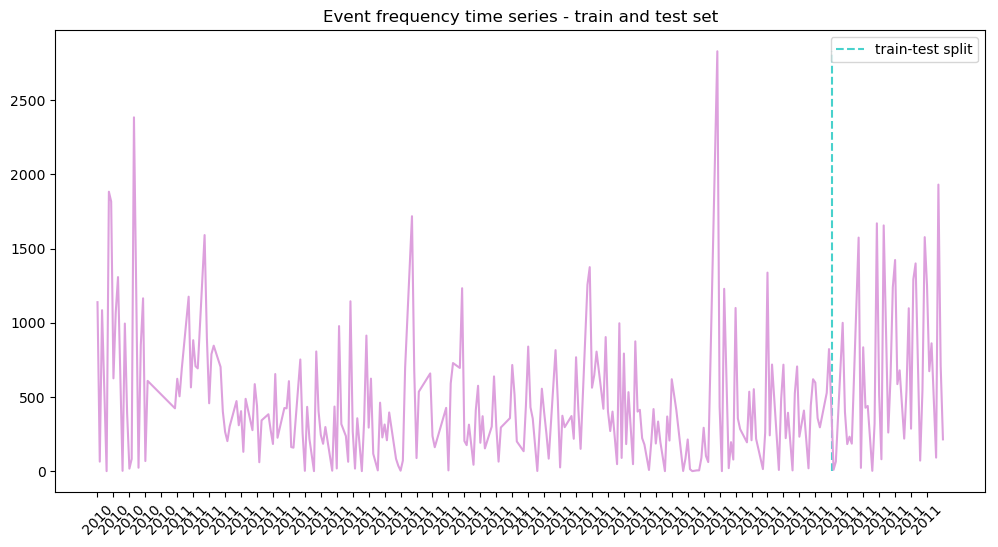

In [99]:
# Visualize train and test set
data = pd.DatetimeIndex(df_newCostumers['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-",color='plum')
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='mediumturquoise', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

# Create the train and test Rating Matrices

<img src="./images/MaskTrain.png" alt="MaskTrain" style="width: 600px;"/>

In [100]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
#    the real value in the categories array
user_cat = df_newCostumers['CustomerID'].astype('category')
item_cat = df_newCostumers['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_newCostumers['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()
item_user_train.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_newCostumers['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()
item_user_test.eliminate_zeros()  # remove zero entries
# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (3804, 1) and test set shape: (3804, 1)
train set percentage of zeros: 3.8117770767613024 and test set percentage of zeros: 34.01682439537329


In [101]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

<ipython-input-101-6375e4a41bf5>:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
<ipython-input-101-6375e4a41bf5>:3: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]


set()

# Evaluation
**Note**: We are measuring how well the model will rank the items in the test set for a user, given different items in the training set i.e. **the train and test set have the same users**. We are not making inference for new users that didn't appear in the training set. For new users in production, there is a `recalculate_user` method which can be used for generating recommendations without recalculating the whole model. Also, the `recommend(recalculate_user=True)` method allows the model to recommend for new users on the fly ([github issue](https://github.com/benfred/implicit/issues/152)).

In [102]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [103]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [104]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model
auc,0.501992
map,1.000000
ndcg,1.000000
precision,1.000000


## Association Rules - what to recommend

In [105]:
df_ar = df_apriori.copy()

In [106]:
bla = df_ar.groupby(['InvoiceNo','StockCode']).agg({'CustomerID':'count'}).reset_index()
bla = bla[['InvoiceNo','StockCode']]

In [107]:
mostprod = df_ar['StockCode'].value_counts()
mostprod = pd.DataFrame(mostprod).rename(columns = {'StockCode': 'ntimes'}, inplace = False)
ar_items = list(mostprod[:400].index)

In [108]:
bla = bla[bla['StockCode'].isin(ar_items)]

In [109]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(bla, index='InvoiceNo', columns='StockCode', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

StockCode,15036,15056N,20676,20685,20711,20712,20713,20717,20718,20719,...,84997D,85014B,85049E,85066,85099B,85099C,85099F,85123A,85150,85152
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 3% of the transactions
frequent_itemsets = apriori(pt, min_support=0.03, use_colnames=True)
# length of the itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [111]:
frequent_itemsets.sort_values(by='support', ascending=False).head(10)

,support,itemsets,length
143,0.118526,(85123A),1
140,0.112503,(85099B),1
61,0.107126,(22423),1
120,0.090670,(47566),1
7,0.084162,(20725),1
135,0.078301,(84879),1
49,0.074859,(22197),1
82,0.074697,(22720),1
18,0.070987,(21212),1
56,0.069105,(22383),1


In [112]:
frequent_itemsets['length'].value_counts()

1    145
2     15
Name: length, dtype: int64

#### By confidence

In [113]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(22698),(22697),0.041248,0.054585,0.034041,0.825293,15.119537,0.031790,5.411445
11,(22698),(22699),0.041248,0.057327,0.032213,0.780965,13.622927,0.029848,4.303750
9,(22697),(22699),0.054585,0.057327,0.041301,0.756650,13.198791,0.038172,3.873736
8,(22699),(22697),0.057327,0.054585,0.041301,0.720450,13.198791,0.038172,3.381922
4,(22386),(85099B),0.065501,0.112503,0.044367,0.677340,6.020619,0.036998,2.750562
13,(22726),(22727),0.052810,0.056521,0.034418,0.651731,11.530867,0.031433,2.709055
14,(85099C),(85099B),0.050175,0.112503,0.031460,0.627010,5.573253,0.025815,2.379409
7,(22697),(22698),0.054585,0.041248,0.034041,0.623645,15.119537,0.031790,2.547470
3,(21931),(85099B),0.063673,0.112503,0.038935,0.611486,5.435273,0.031772,2.284339
12,(22727),(22726),0.056521,0.052810,0.034418,0.608944,11.530867,0.031433,2.422133


In [114]:
rulesConfidence['length_ante'] = rulesConfidence['antecedents'].apply(lambda x: len(x))
rulesConfidence['length_conse'] = rulesConfidence['consequents'].apply(lambda x: len(x))

In [115]:
rulesConfidence['length_conse'].unique()

array([1], dtype=int64)

#### By Lift

In [116]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
18,(22698),(22697),0.041248,0.054585,0.034041,0.825293,15.119537,0.031790,5.411445
19,(22697),(22698),0.054585,0.041248,0.034041,0.623645,15.119537,0.031790,2.547470
22,(22699),(22698),0.057327,0.041248,0.032213,0.561914,13.622927,0.029848,2.188501
23,(22698),(22699),0.041248,0.057327,0.032213,0.780965,13.622927,0.029848,4.303750
21,(22697),(22699),0.054585,0.057327,0.041301,0.756650,13.198791,0.038172,3.873736
20,(22699),(22697),0.057327,0.054585,0.041301,0.720450,13.198791,0.038172,3.381922
24,(22727),(22726),0.056521,0.052810,0.034418,0.608944,11.530867,0.031433,2.422133
25,(22726),(22727),0.052810,0.056521,0.034418,0.651731,11.530867,0.031433,2.709055
10,(22383),(20727),0.069105,0.068459,0.031406,0.454475,6.638615,0.026675,1.707603
11,(20727),(22383),0.068459,0.069105,0.031406,0.458759,6.638615,0.026675,1.719927


### Exploration

In [120]:
# High Confidence and high Lift - complementary products
rulesLift[(rulesLift['confidence'] >= 0.5) & (rulesLift['lift'] >= 1.5) & (rulesLift['support'] > 0.035)].sort_values('confidence', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(22697),(22699),0.054585,0.057327,0.041301,0.756650,13.198791,0.038172,3.873736
20,(22699),(22697),0.057327,0.054585,0.041301,0.720450,13.198791,0.038172,3.381922
15,(22386),(85099B),0.065501,0.112503,0.044367,0.677340,6.020619,0.036998,2.750562
13,(21931),(85099B),0.063673,0.112503,0.038935,0.611486,5.435273,0.031772,2.284339
17,(22411),(85099B),0.063189,0.112503,0.036569,0.578723,5.144054,0.029460,2.106684
4,(22383),(20725),0.069105,0.084162,0.035225,0.509728,6.056476,0.029409,1.868018


In [121]:
good_items = ['22697','22699','22727','22726','22384','20725','22386','85099B']

In [122]:
df_ar[df_ar['StockCode'].isin(good_items)][['StockCode','Description']].drop_duplicates()

,StockCode,Description
41,22726,ALARM CLOCK BAKELIKE GREEN
42,22727,ALARM CLOCK BAKELIKE RED
87,20725,LUNCH BAG RED RETROSPOT
97,22386,JUMBO BAG PINK POLKADOT
173,85099B,JUMBO BAG RED RETROSPOT
335,22384,LUNCH BAG PINK POLKADOT
1006,22699,ROSES REGENCY TEACUP AND SAUCER
1012,22697,GREEN REGENCY TEACUP AND SAUCER
56105,20725,LUNCH BAG RED SPOTTY
167000,22726,noDescription
